In [1]:
import sys
sys.path.append('../')
from unicodedata import name
from models.models import ConvPredictor, GradCAM
import json
import h5py
import ast
import numpy as np
import spectral
from spectral import imshow
from PIL import Image
spectral.settings.envi_support_nonlowercase_params = True
from dataloaders.dataloaders import dataset_iron_balanced_mixed
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from trainer import train_regression
from configs.training_cfg import *
import torch
import random
import os

torch.autograd.set_detect_anomaly(True)
pool = torch.nn.AvgPool2d(3,3)
mask_rgb_values = [[255,242,0],[34,177,76],[255,0,88]]

In [2]:
def z_score_normalization(wave):
    # 计算均值和标准差
    mean_value = np.mean(wave)
    std_value = np.std(wave)
    # 按照公式进行归一化
    wave_normalized = (wave - mean_value) / std_value
    # 返回归一化后的张量
    return wave_normalized

# 定义一个最大最小归一化的函数
def min_max_normalization(wave):
    # 计算最大值和最小值
    max_value = np.max(wave)
    min_value = np.min(wave)
    # 按照公式进行归一化
    wave_normalized = (wave - min_value) / (max_value - min_value)
    # 返回归一化后的张量
    return wave_normalized

In [3]:
torch.autograd.set_detect_anomaly(True)
mask_rgb_values = [[255,242,0],[34,177,76],[255,0,88]]

def test_data_avg(list, pool_size=3):
    pool = torch.nn.AvgPool2d(pool_size, pool_size)
    test_data_list = []
    for id in list:
        pixel_list = []
        imgid, sampleid = id.split('_')
        sampleid = ord(sampleid) - 65
        img_data = spectral.envi.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(imgid))
        gt = ast.literal_eval(img_data.metadata['gt_TFe'])
        img_data = torch.Tensor(img_data.asarray()/6000)[:,:,:]
        img_data = pool(img_data.permute(2,0,1)).permute(1,2,0)
        mask = np.array(Image.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr_mask.png".format(imgid)))
        mask = pool(torch.tensor(mask, dtype=float).permute(2,0,1)).permute(1,2,0)
        print(img_data.shape)
        row, col, _ = img_data.shape
        for r in range(row):
            for c in range(col):
                if mask[r,c].tolist() == mask_rgb_values[sampleid]:
                    pixel_list.append(img_data[r,c].unsqueeze(0))

        pixel_list = torch.cat(pixel_list, dim=0)
        test_data_list.append({
            "tensor": torch.mean(pixel_list, dim=0).to(device),
            "gt": torch.Tensor([gt[sampleid]]).to(device)
        })
    return test_data_list


In [ ]:
def test_data(list, pool_size=3):
    pool = torch.nn.AvgPool2d(pool_size, pool_size)
    test_data_list = []
    for id in list:
        pixel_list = []
        imgid, sampleid = id.split('_')
        sampleid = ord(sampleid) - 65
        img_data = spectral.envi.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(imgid))
        gt = ast.literal_eval(img_data.metadata['gt_TFe'])
        img_data = torch.Tensor(img_data.asarray()/6000)[:,:,:]
        img_data = pool(img_data.permute(2,0,1)).permute(1,2,0)
        mask = np.array(Image.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr_mask.png".format(imgid)))
        mask = pool(torch.tensor(mask, dtype=float).permute(2,0,1)).permute(1,2,0)
        print(img_data.shape)
        row, col, _ = img_data.shape
        for r in range(row):
            for c in range(col):
                if mask[r,c].tolist() == mask_rgb_values[sampleid]:
                    pixel_list.append(img_data[r,c].unsqueeze(0))

        pixel_list = torch.cat(pixel_list, dim=0)
        test_data_list.append({
            "tensor": pixel_list.to(device),
            "gt": torch.Tensor([gt[sampleid]]).to(device)
        })
    return test_data_list

In [4]:
# all dataset
ci_samples = ['7_C','46_B','6_A','59_B','5_A','28_B','54_B','36_A','41_C','37_A','44_B','19_C','51_C','39_B','28_A','39_C','30_A',
              '39_A','54_A','61_C','61_A','37_B','48_C','48_C','21_A','22_A','48_B','48_A','38_B','57_C','61_B','37_C']
chi_samples = ['13_A','11_A','12_A','12_C','25_A','42_B','15_A','56_B',
               '4_B','42_A','57_A','14_B','36_B','43_C','26_A','9_C','43_A','53_A','3_B','30_C','27_A','22_B'
               ,'27_C','31_C','53_B','6_B','52_B','8_B','41_B','34_A','7_B','53_C','54_C','29_B','16_B','47_A','49_B','10_C',
            '21_C','50_A','18_A','22_C','52_C','38_A','17_A',
            '59_A','4_A','57_B','33_C','7_A','49_C','58_B','4_C',
            '52_A','17_C','23_A','30_B','46_A','18_C','24_A','55_A','40_A','55_B','3_C','27_B','18_B','29_A','25_B','32_C','45_C','12_B','20_A','29_C',
            '14_C','19_A','23_B','9_B','40_B','35_C','13_C','50_B','35_B','15_B','45_A','23_C','1_C','32_B','6_C','51_B','38_C','2_A','26_B','2_C',
            '16_C','43_B','24_C','15_C','42_C','1_A','14_A','11_C','16_A','13_B','21_B','36_C','34_B','56_A','47_C','8_A','19_B','3_A','62_A','33_B','24_B',
            '60_B','11_B','59_C','10_B','8_C','41_A']

jia_samples = ['55_C','32_A','31_A','49_A','9_A','28_C','5_C','46_C','1_B','35_A','2_B','58_C','10_A']


pt_path_list = ['D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold0_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold1_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold2_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold3_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold4_step100000.pt']

data_ci = []
for id in ci_samples:
    imgid, sampleid = id.split('_')
    sampleid = ord(sampleid) - 65
    metadata = spectral.envi.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(imgid)).metadata
    gt = ast.literal_eval(metadata['gt_TFe'])
    data_ci.append(id)

data_chi = []
for id in chi_samples:
    imgid, sampleid = id.split('_')
    sampleid = ord(sampleid) - 65
    metadata = spectral.envi.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(imgid)).metadata
    gt = ast.literal_eval(metadata['gt_TFe'])
    data_chi.append(id)

data_jia = []
for id in jia_samples:
    imgid, sampleid = id.split('_')
    sampleid = ord(sampleid) - 65
    metadata = spectral.envi.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(imgid)).metadata
    gt = ast.literal_eval(metadata['gt_TFe'])
    data_jia.append(id)



In [5]:
tdl_ci = test_data_avg(data_ci)
tdl_chi = test_data_avg(data_chi)
tdl_jia = test_data_avg(data_jia)

torch.Size([174, 106, 168])
torch.Size([175, 106, 168])
torch.Size([170, 106, 168])
torch.Size([227, 106, 168])
torch.Size([169, 106, 168])
torch.Size([188, 106, 168])
torch.Size([169, 106, 168])
torch.Size([178, 106, 168])
torch.Size([166, 106, 168])
torch.Size([135, 106, 168])
torch.Size([178, 106, 168])
torch.Size([169, 106, 168])
torch.Size([187, 106, 168])
torch.Size([136, 106, 168])
torch.Size([188, 106, 168])
torch.Size([136, 106, 168])
torch.Size([179, 106, 168])
torch.Size([136, 106, 168])
torch.Size([169, 106, 168])
torch.Size([165, 106, 168])
torch.Size([165, 106, 168])
torch.Size([135, 106, 168])
torch.Size([162, 106, 168])
torch.Size([162, 106, 168])
torch.Size([167, 106, 168])
torch.Size([173, 106, 168])
torch.Size([162, 106, 168])
torch.Size([162, 106, 168])
torch.Size([157, 106, 168])
torch.Size([170, 106, 168])
torch.Size([165, 106, 168])
torch.Size([135, 106, 168])
torch.Size([162, 106, 168])
torch.Size([145, 106, 168])
torch.Size([149, 106, 168])
torch.Size([149, 106

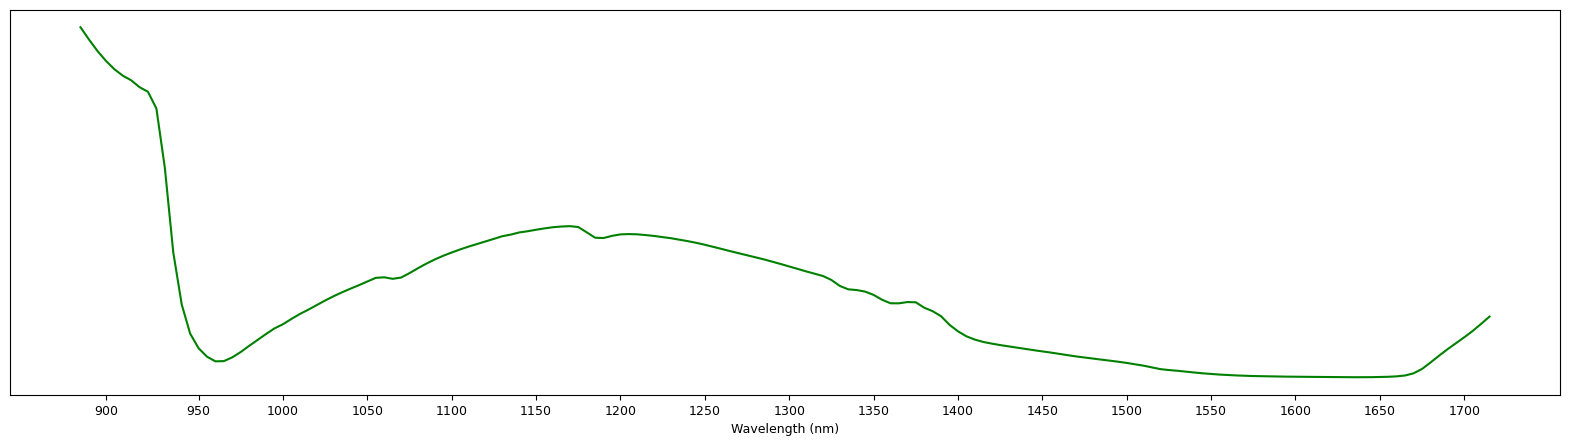

In [6]:




fig = plt.figure(figsize=(20, 5))

x_values = np.array([886.49, 891.36, 896.22, 901.09, 905.96, 910.83, 915.7, 920.57, 925.44, 930.32, 935.19, 
                     940.07, 944.95, 949.83, 954.71, 959.6, 964.48, 969.37, 974.26, 979.15, 984.04, 988.93, 
                     993.82, 998.72, 1003.62, 1008.51, 1013.41, 1018.32, 1023.22, 1028.12, 1033.03, 1037.93, 
                     1042.84, 1047.75, 1052.66, 1057.58, 1062.49, 1067.41, 1072.32, 1077.24, 1082.16, 1087.08, 
                     1092.01, 1096.93, 1101.86, 1106.79, 1111.71, 1116.64, 1121.58, 1126.51, 1131.44, 1136.38, 
                     1141.32, 1146.26, 1151.2, 1156.14, 1161.08, 1166.03, 1170.97, 1175.92, 1180.87, 1185.82, 
                     1190.77, 1195.73, 1200.68, 1205.64, 1210.6, 1215.56, 1220.52, 1225.48, 1230.44, 1235.41, 
                     1240.38, 1245.34, 1250.31, 1255.29, 1260.26, 1265.23, 1270.21, 1275.18, 1280.16, 1285.14, 
                     1290.12, 1295.11, 1300.09, 1305.08, 1310.06, 1315.05, 1320.04, 1325.03, 1330.03, 1335.02, 
                     1340.02, 1345.01, 1350.01, 1355.01, 1360.01, 1365.02, 1370.02, 1375.03, 1380.04, 1385.05, 
                     1390.06, 1395.07, 1400.08, 1405.1, 1410.11, 1415.13, 1420.15, 1425.17, 1430.19, 1435.22, 
                     1440.24, 1445.27, 1450.29, 1455.32, 1460.35, 1465.39, 1470.42, 1475.46, 1480.49, 1485.53, 
                     1490.57, 1495.61, 1500.65, 1505.7, 1510.74, 1515.79, 1520.84, 1525.89, 1530.94, 1535.99, 
                     1541.05, 1546.1, 1551.16, 1556.22, 1561.28, 1566.34, 1571.4, 1576.47, 1581.53, 1586.6, 
                     1591.67, 1596.74, 1601.81, 1606.88, 1611.96, 1617.03, 1622.11, 1627.19, 1632.27, 1637.35, 
                     1642.43, 1647.52, 1652.61, 1657.69, 1662.78, 1667.87, 1672.96, 1678.06, 1683.15, 1688.25, 
                     1693.35, 1698.45, 1703.55, 1708.65, 1713.75, 1718.86])


# spec_data = data_tensor[0]['tensor'][idx].unsqueeze(0).squeeze(0).cpu().detach().numpy()



# 添加曲线图
# plt.plot(spec_data, color='blue', linewidth=1.5)
# plt.plot(spec_data_diff1, color='green', linewidth=1.5)
# plt.plot(spec_data_diff2, color='red', linewidth=1.5)

# # 将tdl_ci中的数据画在图上
# for idx in range(tdl_ci.__len__()):
#     plt.plot(tdl_ci[idx]['tensor'].cpu().detach().numpy(), color='blue', linewidth=1.5)

# 将tdl_chi中的数据画在图上
for idx in range(tdl_chi.__len__()):
    plt.plot(tdl_chi[idx]['tensor'].cpu().detach().numpy(), color='green', linewidth=1.5)
    break

# # 将tdl_jia中的数据画在图上
# for idx in range(tdl_jia.__len__()):
#     plt.plot(tdl_jia[idx]['tensor'].cpu().detach().numpy(), color='red', linewidth=1.5)

ticks = []
labels = []
cur_band = 900 # 第一个整百波长
for idx in range(x_values.__len__()):
    if x_values[idx] >= cur_band:
        ticks.append(idx)
        labels.append(str(cur_band))
        cur_band += 50
    else:
        continue


# 设置x轴的标签
plt.xticks(ticks, labels, rotation='horizontal')  # 添加 rotation='horizontal' 使得x轴标签水平显示

# 添加x轴的单位
plt.xlabel('Wavelength (nm)')  # 添加x轴的单位

# 清除y轴的标签
plt.yticks([])  # 清除y轴的标签


# 显示图表
plt.show()

# 保存图表，文件名称为{}.png, 其中{}为output保留3位小数的字符串
# fig.savefig('可视化波段_赤铁矿/{}.png'.format(round(output, 5)), dpi=300, bbox_inches='tight')


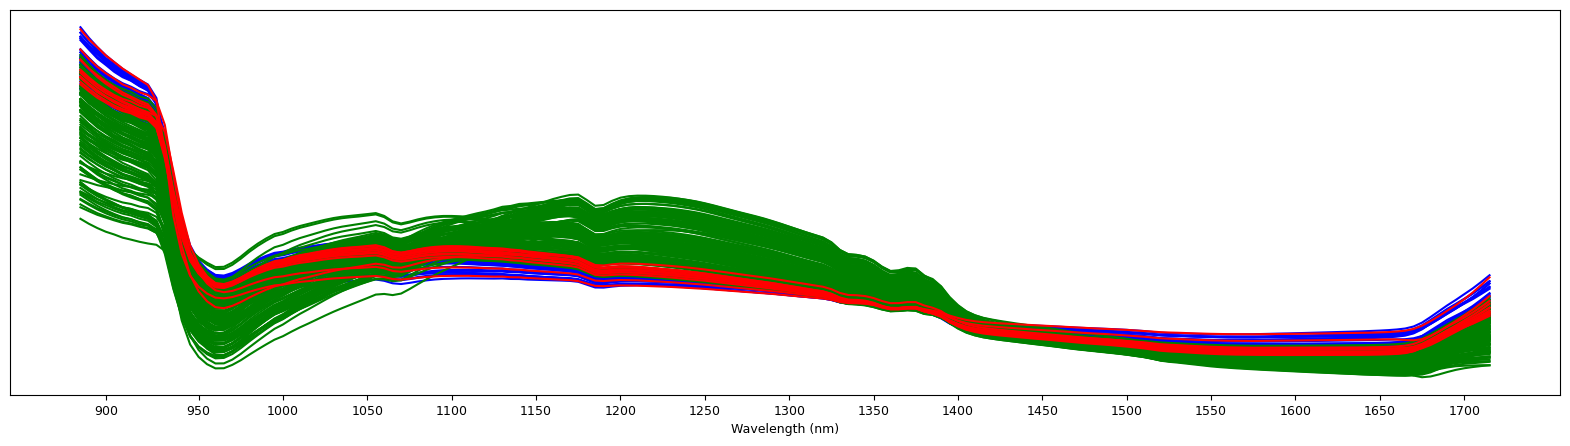

In [7]:
# 同样的格式画另一张图
fig = plt.figure(figsize=(20, 5))

# 将z-score后的tdl_ci数据画在图上
for idx in range(tdl_ci.__len__()):
    plt.plot(z_score_normalization(tdl_ci[idx]['tensor'].cpu().detach().numpy()), color='blue', linewidth=1.5)

# 将z-score后的tdl_chi数据画在图上
for idx in range(tdl_chi.__len__()):
    plt.plot(z_score_normalization(tdl_chi[idx]['tensor'].cpu().detach().numpy()), color='green', linewidth=1.5)

# 将z-score后的tdl_jia数据画在图上
for idx in range(tdl_jia.__len__()):
    plt.plot(z_score_normalization(tdl_jia[idx]['tensor'].cpu().detach().numpy()), color='red', linewidth=1.5)


# 设置x轴的标签
plt.xticks(ticks, labels, rotation='horizontal')  # 添加 rotation='horizontal' 使得x轴标签水平显示

# 添加x轴的单位
plt.xlabel('Wavelength (nm)')  # 添加x轴的单位

# 清除y轴的标签
plt.yticks([])  # 清除y轴的标签

# 显示图表
plt.show()